<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/shiftVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shift-VAE: Application to 1D spectra with arbitrary offset in peak position

Prepared by Maxim Ziatdinov


---

This notebook denonstrates how to use shift-VAE to disentangle the representations of a 1D spectral data set, ignoring relative positions of the peaks. 

---



E-mail: ziatdinovmax@gmail.com

Install pyroVED package:

In [1]:
# Install the latest version from source
# (or you may instal a stable version from PyPi instead with !pip install pyroved)
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

     |████████████████████████████████| 722 kB 7.2 MB/s 


Imports:

In [2]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt

First, we prepare our synthetic data representing 1D Gaussian signals with different widths that is randomly shifted along the *x*-axis and is corrupted by noise. In other words, in this example we assume that the only physical factor of variation is a signal width and other forms of variations are considered to be "instrumental distortion".

In [3]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

n_samples = 5000 # number of samples
l_signal = 100 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
torch.manual_seed(1)  # for reproducibility
x = torch.linspace(-12, 12, l_signal).expand(n_samples, l_signal)
noise = torch.randint(1, 100, (n_samples, 1)) / 1e3
mu = torch.randint(-30, 30, size=(n_samples, 1)) / 10
sig = torch.randint(50, 500, size=(n_samples, 1)) / 1e2
train_data = gaussian(x, mu, sig) + noise * torch.randn(size=(n_samples, l_signal))
# Normalize to (0, 1)
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

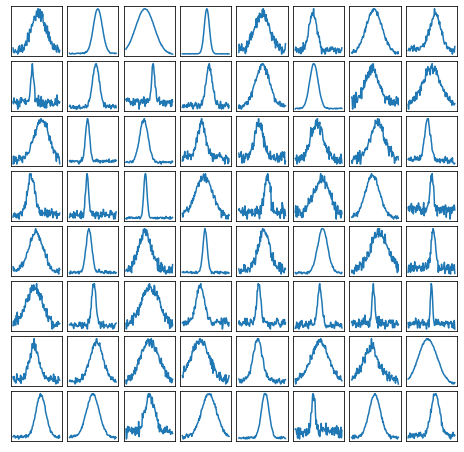

In [4]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x[0], y[0, 0])

Our goal is to find the real/physical descriptor of the data set in an unsupervised fashion, while ignoring (or separating) relative positions of the peaks. First, let's train a regular VAE:

In [5]:
in_dim = (100,)

# Initialize vanilla VAE
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 62.4043
Epoch: 2 Training loss: 61.2139
Epoch: 3 Training loss: 60.5367
Epoch: 4 Training loss: 60.2476
Epoch: 5 Training loss: 60.1773
Epoch: 6 Training loss: 60.1729
Epoch: 7 Training loss: 60.1961
Epoch: 8 Training loss: 60.1787
Epoch: 9 Training loss: 60.1297
Epoch: 10 Training loss: 60.1356
Epoch: 11 Training loss: 60.1094
Epoch: 12 Training loss: 60.1139
Epoch: 13 Training loss: 60.1153
Epoch: 14 Training loss: 60.0849
Epoch: 15 Training loss: 60.1391
Epoch: 16 Training loss: 60.0918
Epoch: 17 Training loss: 60.1028
Epoch: 18 Training loss: 60.1007
Epoch: 19 Training loss: 60.0903
Epoch: 20 Training loss: 60.0951
Epoch: 21 Training loss: 60.1024
Epoch: 22 Training loss: 60.1430
Epoch: 23 Training loss: 60.0916
Epoch: 24 Training loss: 60.1116
Epoch: 25 Training loss: 60.0919
Epoch: 26 Training loss: 60.0884
Epoch: 27 Training loss: 60.0925
Epoch: 28 Training loss: 60.0699
Epoch: 29 Training loss: 60.0835
Epoch: 30 Training loss: 60.0763
Epoch: 31 Training 

Encode the training data into the latent space:

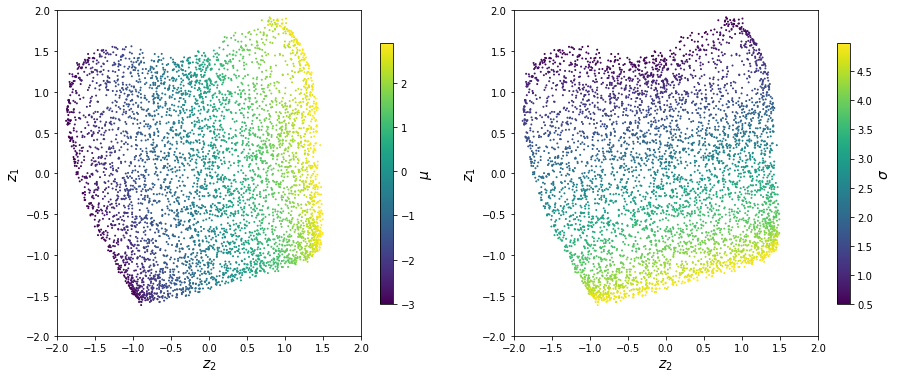

In [6]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig)
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

Plot the learned latent manifold:

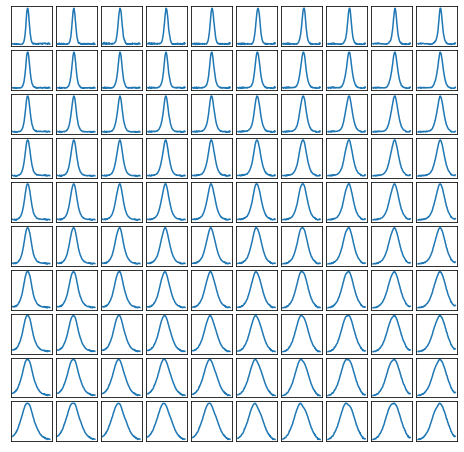

In [7]:
vae.manifold2d(d=10);

The results are not that bad! We can see that one of the latent variables is (mostly) associated with peak shifts and another one is (mostly) associated with changes in width. Now let's plot our latent variables versus the ground truth data (i.e., actual peak shift and changes in width):

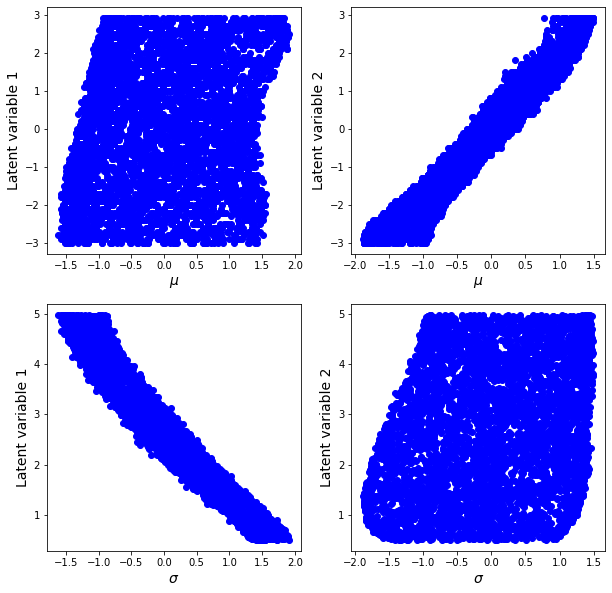

In [8]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(z_mean[:, 0], mu, c='blue')
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("Latent variable 1", fontsize=14)
ax[0, 1].scatter(z_mean[:, 1], mu, c='blue')
ax[0, 1].set_xlabel("$\mu$", fontsize=14)
ax[0, 1].set_ylabel("Latent variable 2", fontsize=14)
ax[1, 0].scatter(z_mean[:, 0], sig, c='blue')
ax[1, 0].set_xlabel("$\sigma$", fontsize=14)
ax[1, 0].set_ylabel("Latent variable 1", fontsize=14)
ax[1, 1].scatter(z_mean[:, 1], sig, c='blue')
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("Latent variable 2", fontsize=14);

We can see that while there is definitely a relationship between ground truth variables and the encoded latent variables, they are not equal (even after if we do a "rescaling").

Now let's see if a shift-invariant VAE model can do better. In the shift-VAE, we have one latent variable designated to absorb the information about shifts, whereas the remaining latent variables encode the remaining factors of variation.

Let's initialize and train the shift-VAE model:

In [9]:
in_dim = (100,)

# Initialize shift-invariant VAE (to do this we add 't' to invariances)
svae = pv.models.iVAE(in_dim, latent_dim=2, invariances=['t'], dx_prior=.3)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(svae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 65.0912
Epoch: 2 Training loss: 61.7285
Epoch: 3 Training loss: 60.9334
Epoch: 4 Training loss: 60.8464
Epoch: 5 Training loss: 60.7520
Epoch: 6 Training loss: 60.6943
Epoch: 7 Training loss: 60.7085
Epoch: 8 Training loss: 60.6276
Epoch: 9 Training loss: 60.6231
Epoch: 10 Training loss: 60.6109
Epoch: 11 Training loss: 60.6310
Epoch: 12 Training loss: 60.6065
Epoch: 13 Training loss: 60.5824
Epoch: 14 Training loss: 60.5638
Epoch: 15 Training loss: 60.5601
Epoch: 16 Training loss: 60.5462
Epoch: 17 Training loss: 60.5450
Epoch: 18 Training loss: 60.5440
Epoch: 19 Training loss: 60.5456
Epoch: 20 Training loss: 60.5469
Epoch: 21 Training loss: 60.5121
Epoch: 22 Training loss: 60.5336
Epoch: 23 Training loss: 60.5181
Epoch: 24 Training loss: 60.5043
Epoch: 25 Training loss: 60.5614
Epoch: 26 Training loss: 60.5497
Epoch: 27 Training loss: 60.5286
Epoch: 28 Training loss: 60.5110
Epoch: 29 Training loss: 60.5055
Epoch: 30 Training loss: 60.5109
Epoch: 31 Training 

Encode train data into the latent space:

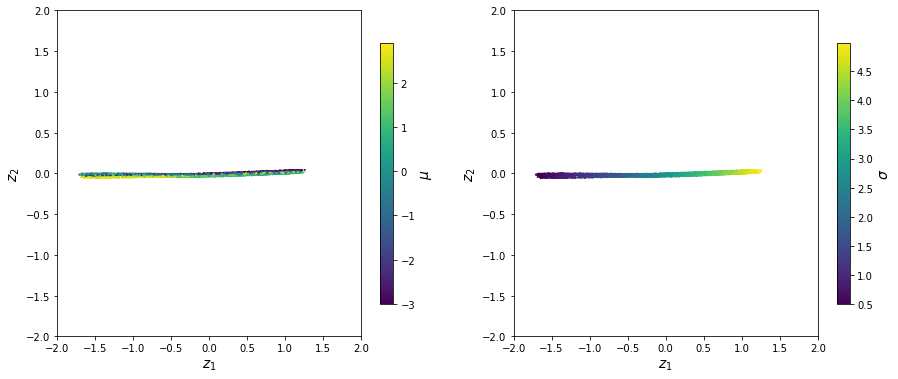

In [10]:
z_mean, z_sd = svae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig)
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

Note that the latent space is clearly collapsed, with the data points forming an 1D manifold. Classically in VAEs, this collapse of latent space is perceived as a problem calling for the adjustment of the "loss" function. However, here we know that our ground truth data set has only two factors of variability, one of which is position. Hence, the dimensionality of our latent space hints at the true physical dimensionality of the data!

Now let's plot the learned latent manifold of the shift-VAE:

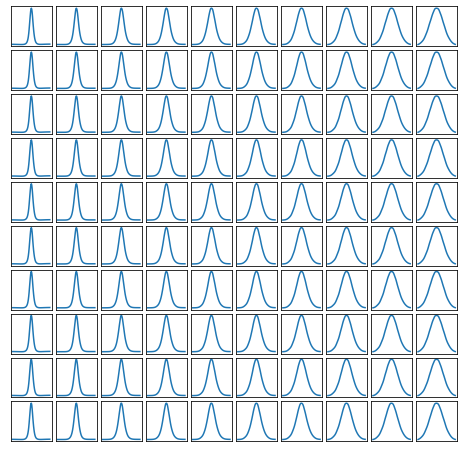

In [11]:
svae.manifold2d(d=10);

As mentioned above, the information about shifts is now encoded in the first latent variables so let's plot it against the real shift. We also plot a non-collapsed latent variable against the ground truth values of peak width.

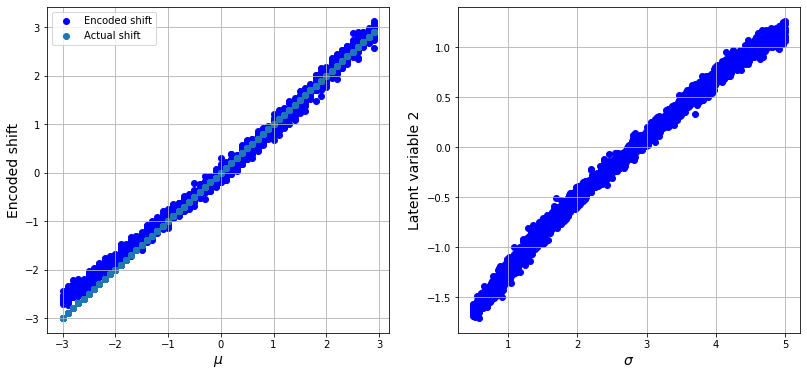

In [13]:
rescale = ((x.max() - x.min()) / 2 ) * svae.t_prior.cpu() # rescaling coefficient for shift latent variable
i = 2 # non-collapsed latent variable 
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.5, 6))
ax1.scatter(mu, z_mean[:, 0] * rescale, c='blue', label="Encoded shift")
ax1.scatter(mu, mu, label="Actual shift")
ax1.set_xlabel("$\mu$", fontsize=14)
ax1.set_ylabel("Encoded shift", fontsize=14)
ax1.legend()
ax1.grid()
ax2.scatter(sig, z_mean[:, i], c='blue')
ax2.set_xlabel("$\sigma$", fontsize=14)
ax2.set_ylabel("Latent variable {}".format(i), fontsize=14)
ax2.grid()

Looks pretty good! We see mostly linear relationships and a big improvement compared to standard VAE. You may try playing with a KL scale factor and/or parameters of the encoder and decoder neural networks to get a further improvememnt.